In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time
import shap


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA

from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

c:\ProgramData\anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FD001

In [2]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "P30", "BPR"] # selection based on main_notebook
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)

## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(20631, 27) (13096, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,-0.0,100.0,0.0,0.168712,0.419699,0.281998,0.0,...,0.186883,0.364675,0.0,0.333333,0.0,0.0,0.779661,0.750000,120,-0.0_-0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.231676,0.437236,0.301955,0.0,...,0.180816,0.382647,0.0,0.301435,0.0,0.0,0.749952,0.736399,120,0.0_-0.0_100.0
2,1,3,-0.0,0.0,100.0,0.0,0.279270,0.414066,0.334500,0.0,...,0.168127,0.371184,0.0,0.227105,0.0,0.0,0.713728,0.699766,120,-0.0_0.0_100.0
3,1,4,0.0,0.0,100.0,0.0,0.295582,0.363296,0.318775,0.0,...,0.168159,0.315365,0.0,0.266806,0.0,0.0,0.671042,0.684862,120,0.0_0.0_100.0
4,1,5,-0.0,-0.0,100.0,0.0,0.305799,0.336489,0.335855,0.0,...,0.166419,0.338028,0.0,0.310184,0.0,0.0,0.664455,0.695191,120,-0.0_-0.0_100.0


In [3]:
# 1layers
def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation):
    
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(units = nodes_per_layer, activation=activation, 
                  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.001))
    # model.save_weights(weights_file)

    return model

In [4]:
# import tensorflow as tf

# tf.compat.v1.enable_eager_execution()  # Nécessaire pour TensorFlow 1.x


In [5]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 21	13.768992	0.0	3.830708e+02	0.0	189.585159	0.0	0.10	[128]	0.2	tanh	64	30
results001 = pd.DataFrame()

for SEED in range(1):  
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 30
    epochs = 30
    nodes_per_layer = [128]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 64
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results001 = pd.concat([results001, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results001.to_csv('results/base/fd001.csv')

(17731, 30, 4) (17731, 1) (100, 30, 4)

Epoch 1/30

278/278 [==============================] - 4s 11ms/step - loss: 1944.5961 - val_loss: 1542.0682
Epoch 2/30
278/278 [==============================] - 3s 10ms/step - loss: 1115.9581 - val_loss: 699.7667
Epoch 3/30
278/278 [==============================] - 3s 10ms/step - loss: 638.8581 - val_loss: 426.3709
Epoch 4/30
278/278 [==============================] - 3s 10ms/step - loss: 387.9904 - val_loss: 209.8593
Epoch 5/30
278/278 [==============================] - 3s 10ms/step - loss: 298.0899 - val_loss: 229.3895
Epoch 6/30
278/278 [==============================] - 3s 10ms/step - loss: 271.9521 - val_loss: 200.8959
Epoch 7/30
278/278 [==============================] - 3s 10ms/step - loss: 267.7080 - val_loss: 194.5271
Epoch 8/30
278/278 [==============================] - 3s 11ms/step - loss: 259.6712 - val_loss: 319.8610
Epoch 9/30
278/278 [==============================] - 3s 10ms/step - loss: 255.7187 - val_loss: 185.4786
Epoch 10/30

In [6]:
results001

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.755003,0.0,302.835148,0.0,217.710098,0.0,[128],0.2,tanh,64,30,92.393383


In [7]:
import shap
class LSTMModelWrapper:
    def __init__(self, model, input_shape):
        """
        Wrapper for LSTM models to work with SHAP.

        Parameters:
        - model: Trained LSTM model.
        - input_shape: Tuple (timesteps, features) of the original model input shape.
        """
        self.model = model
        self.timesteps, self.features = input_shape

    def predict(self, X_flat):
        """
        Predict function for SHAP that reshapes flat input back to 3D.

        Parameters:
        - X_flat: 2D numpy array [samples, timesteps * features].

        Returns:
        - Predictions from the LSTM model.
        """
        # Reshape to 3D: [samples, timesteps, features]
        X_reshaped = X_flat.reshape(-1, self.timesteps, self.features)
        return self.model.predict(X_reshaped)

def explain_lstm_model(model, X_train, X_test, timesteps, features):
    """
    Explains an LSTM model using SHAP.

    Parameters:
    - model: Trained LSTM model.
    - X_train: Training data in 3D shape [samples, timesteps, features].
    - X_test: Test data in 3D shape [samples, timesteps, features].
    - timesteps: Number of timesteps for the LSTM model input.
    - features: Number of features for the LSTM model input.

    Returns:
    - SHAP values for the test data.
    """
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Wrap the LSTM model
    lstm_wrapper = LSTMModelWrapper(model, (timesteps, features))

    # Use SHAP KernelExplainer
    explainer = shap.KernelExplainer(lstm_wrapper.predict, X_train_flat[:20])  # Use a subset for background data
    shap_values = explainer.shap_values(X_test_flat)

    return shap_values, explainer

In [8]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1430/1430 [==============================] - 6s 4ms/step


  1%|          | 1/100 [00:06<11:02,  6.69s/it]

1430/1430 [==============================] - 6s 4ms/step


  2%|▏         | 2/100 [00:13<11:13,  6.87s/it]

1430/1430 [==============================] - 6s 4ms/step


  3%|▎         | 3/100 [00:20<11:13,  6.94s/it]

1430/1430 [==============================] - 6s 4ms/step


  4%|▍         | 4/100 [00:27<10:57,  6.85s/it]

1430/1430 [==============================] - 7s 5ms/step


  5%|▌         | 5/100 [00:35<11:23,  7.20s/it]

1430/1430 [==============================] - 6s 4ms/step


  6%|▌         | 6/100 [00:42<11:15,  7.18s/it]

1430/1430 [==============================] - 6s 4ms/step


  7%|▋         | 7/100 [00:49<10:50,  7.00s/it]

1430/1430 [==============================] - 6s 4ms/step


  8%|▊         | 8/100 [00:55<10:32,  6.88s/it]

1430/1430 [==============================] - 6s 4ms/step


  9%|▉         | 9/100 [01:02<10:16,  6.78s/it]

1430/1430 [==============================] - 6s 4ms/step


 10%|█         | 10/100 [01:09<10:16,  6.85s/it]

1430/1430 [==============================] - 5s 4ms/step


 11%|█         | 11/100 [01:15<09:45,  6.58s/it]

1430/1430 [==============================] - 6s 4ms/step


 12%|█▏        | 12/100 [01:21<09:45,  6.65s/it]

1430/1430 [==============================] - 6s 4ms/step


 13%|█▎        | 13/100 [01:28<09:38,  6.65s/it]

1430/1430 [==============================] - 5s 4ms/step


 14%|█▍        | 14/100 [01:34<09:21,  6.53s/it]

1430/1430 [==============================] - 6s 4ms/step


 15%|█▌        | 15/100 [01:41<09:18,  6.57s/it]

1430/1430 [==============================] - 5s 4ms/step


 16%|█▌        | 16/100 [01:47<09:00,  6.43s/it]

1430/1430 [==============================] - 5s 4ms/step


 17%|█▋        | 17/100 [01:53<08:42,  6.30s/it]

1430/1430 [==============================] - 6s 4ms/step


 18%|█▊        | 18/100 [02:00<08:51,  6.48s/it]

1430/1430 [==============================] - 5s 4ms/step


 19%|█▉        | 19/100 [02:06<08:36,  6.38s/it]

1430/1430 [==============================] - 5s 3ms/step


 20%|██        | 20/100 [02:12<08:17,  6.22s/it]

1430/1430 [==============================] - 6s 4ms/step


 21%|██        | 21/100 [02:19<08:23,  6.37s/it]

1430/1430 [==============================] - 5s 4ms/step


 22%|██▏       | 22/100 [02:25<08:08,  6.26s/it]

1430/1430 [==============================] - 5s 4ms/step


 23%|██▎       | 23/100 [02:31<07:56,  6.19s/it]

1430/1430 [==============================] - 6s 4ms/step


 24%|██▍       | 24/100 [02:37<07:54,  6.25s/it]

1430/1430 [==============================] - 6s 4ms/step


 25%|██▌       | 25/100 [02:44<08:01,  6.42s/it]

1430/1430 [==============================] - 6s 4ms/step


 26%|██▌       | 26/100 [02:51<08:04,  6.54s/it]

1430/1430 [==============================] - 6s 4ms/step


 27%|██▋       | 27/100 [02:57<07:59,  6.57s/it]

1430/1430 [==============================] - 6s 4ms/step


 28%|██▊       | 28/100 [03:04<07:54,  6.59s/it]

1430/1430 [==============================] - 5s 4ms/step


 29%|██▉       | 29/100 [03:10<07:40,  6.48s/it]

1430/1430 [==============================] - 6s 4ms/step


 30%|███       | 30/100 [03:17<07:31,  6.45s/it]

1430/1430 [==============================] - 6s 4ms/step


 31%|███       | 31/100 [03:23<07:28,  6.49s/it]

1430/1430 [==============================] - 9s 6ms/step


 32%|███▏      | 32/100 [03:33<08:25,  7.44s/it]

1430/1430 [==============================] - 8s 6ms/step


 33%|███▎      | 33/100 [03:42<08:46,  7.86s/it]

1430/1430 [==============================] - 8s 6ms/step


 34%|███▍      | 34/100 [03:51<09:07,  8.30s/it]

1430/1430 [==============================] - 9s 6ms/step


 35%|███▌      | 35/100 [04:01<09:38,  8.90s/it]

1430/1430 [==============================] - 9s 6ms/step


 36%|███▌      | 36/100 [04:11<09:47,  9.19s/it]

1430/1430 [==============================] - 7s 5ms/step


 37%|███▋      | 37/100 [04:20<09:21,  8.91s/it]

1430/1430 [==============================] - 6s 4ms/step


 38%|███▊      | 38/100 [04:27<08:44,  8.46s/it]

1430/1430 [==============================] - 7s 5ms/step


 39%|███▉      | 39/100 [04:34<08:18,  8.17s/it]

1430/1430 [==============================] - 6s 4ms/step


 40%|████      | 40/100 [04:42<07:55,  7.92s/it]

1430/1430 [==============================] - 6s 4ms/step


 41%|████      | 41/100 [04:49<07:38,  7.77s/it]

1430/1430 [==============================] - 6s 4ms/step


 42%|████▏     | 42/100 [05:00<08:27,  8.76s/it]

1430/1430 [==============================] - 6s 4ms/step


 43%|████▎     | 43/100 [05:07<07:46,  8.18s/it]

1430/1430 [==============================] - 7s 5ms/step


 44%|████▍     | 44/100 [05:15<07:26,  7.97s/it]

1430/1430 [==============================] - 6s 4ms/step


 45%|████▌     | 45/100 [05:22<07:07,  7.77s/it]

1430/1430 [==============================] - 6s 4ms/step


 46%|████▌     | 46/100 [05:29<06:50,  7.60s/it]

1430/1430 [==============================] - 7s 5ms/step


 47%|████▋     | 47/100 [05:37<06:42,  7.60s/it]

1430/1430 [==============================] - 7s 5ms/step


 48%|████▊     | 48/100 [05:44<06:34,  7.58s/it]

1430/1430 [==============================] - 7s 5ms/step


 49%|████▉     | 49/100 [05:52<06:30,  7.66s/it]

1430/1430 [==============================] - 7s 5ms/step


 50%|█████     | 50/100 [06:00<06:27,  7.76s/it]

1430/1430 [==============================] - 7s 5ms/step


 51%|█████     | 51/100 [06:08<06:19,  7.74s/it]

1430/1430 [==============================] - 7s 5ms/step


 52%|█████▏    | 52/100 [06:16<06:19,  7.90s/it]

1430/1430 [==============================] - 7s 5ms/step


 53%|█████▎    | 53/100 [06:24<06:19,  8.07s/it]

1430/1430 [==============================] - 7s 5ms/step


 54%|█████▍    | 54/100 [06:32<06:08,  8.00s/it]

1430/1430 [==============================] - 8s 5ms/step


 55%|█████▌    | 55/100 [06:41<06:07,  8.17s/it]

1430/1430 [==============================] - 8s 5ms/step


 56%|█████▌    | 56/100 [06:49<06:04,  8.29s/it]

1430/1430 [==============================] - 8s 5ms/step


 57%|█████▋    | 57/100 [06:58<06:02,  8.44s/it]

1430/1430 [==============================] - 7s 5ms/step


 58%|█████▊    | 58/100 [07:09<06:26,  9.21s/it]

1430/1430 [==============================] - 7s 5ms/step


 59%|█████▉    | 59/100 [07:17<06:02,  8.83s/it]

1430/1430 [==============================] - 9s 7ms/step


 60%|██████    | 60/100 [07:28<06:12,  9.32s/it]

1430/1430 [==============================] - 8s 5ms/step


 61%|██████    | 61/100 [07:36<05:55,  9.12s/it]

1430/1430 [==============================] - 8s 5ms/step


 62%|██████▏   | 62/100 [07:45<05:40,  8.97s/it]

1430/1430 [==============================] - 7s 5ms/step


 63%|██████▎   | 63/100 [07:53<05:25,  8.80s/it]

1430/1430 [==============================] - 7s 5ms/step


 64%|██████▍   | 64/100 [08:01<05:02,  8.40s/it]

1430/1430 [==============================] - 7s 5ms/step


 65%|██████▌   | 65/100 [08:09<04:49,  8.26s/it]

1430/1430 [==============================] - 7s 5ms/step


 66%|██████▌   | 66/100 [08:17<04:36,  8.12s/it]

1430/1430 [==============================] - 7s 5ms/step


 67%|██████▋   | 67/100 [08:25<04:26,  8.09s/it]

1430/1430 [==============================] - 7s 5ms/step


 68%|██████▊   | 68/100 [08:32<04:15,  7.98s/it]

1430/1430 [==============================] - 7s 5ms/step


 69%|██████▉   | 69/100 [08:43<04:36,  8.91s/it]

1430/1430 [==============================] - 7s 5ms/step


 70%|███████   | 70/100 [08:51<04:17,  8.58s/it]

1430/1430 [==============================] - 7s 5ms/step


 71%|███████   | 71/100 [08:59<04:02,  8.35s/it]

1430/1430 [==============================] - 7s 5ms/step


 72%|███████▏  | 72/100 [09:07<03:52,  8.31s/it]

1430/1430 [==============================] - 7s 5ms/step


 73%|███████▎  | 73/100 [09:15<03:40,  8.16s/it]

1430/1430 [==============================] - 8s 5ms/step


 74%|███████▍  | 74/100 [09:24<03:37,  8.35s/it]

1430/1430 [==============================] - 7s 5ms/step


 75%|███████▌  | 75/100 [09:32<03:26,  8.26s/it]

1430/1430 [==============================] - 7s 5ms/step


 76%|███████▌  | 76/100 [09:40<03:16,  8.18s/it]

1430/1430 [==============================] - 7s 5ms/step


 77%|███████▋  | 77/100 [09:48<03:05,  8.05s/it]

1430/1430 [==============================] - 7s 5ms/step


 78%|███████▊  | 78/100 [09:56<02:59,  8.16s/it]

1430/1430 [==============================] - 7s 5ms/step


 79%|███████▉  | 79/100 [10:04<02:49,  8.07s/it]

1430/1430 [==============================] - 7s 5ms/step


 80%|████████  | 80/100 [10:12<02:41,  8.08s/it]

1430/1430 [==============================] - 7s 5ms/step


 81%|████████  | 81/100 [10:20<02:32,  8.00s/it]

1430/1430 [==============================] - 8s 5ms/step


 82%|████████▏ | 82/100 [10:29<02:29,  8.28s/it]

1430/1430 [==============================] - 7s 5ms/step


 83%|████████▎ | 83/100 [10:37<02:18,  8.16s/it]

1430/1430 [==============================] - 7s 5ms/step


 84%|████████▍ | 84/100 [10:45<02:10,  8.19s/it]

1430/1430 [==============================] - 7s 5ms/step


 85%|████████▌ | 85/100 [10:53<02:02,  8.14s/it]

1430/1430 [==============================] - 7s 5ms/step


 86%|████████▌ | 86/100 [11:01<01:52,  8.06s/it]

1430/1430 [==============================] - 6s 5ms/step


 87%|████████▋ | 87/100 [11:08<01:42,  7.89s/it]

1430/1430 [==============================] - 6s 5ms/step


 88%|████████▊ | 88/100 [11:16<01:33,  7.75s/it]

1430/1430 [==============================] - 6s 4ms/step


 89%|████████▉ | 89/100 [11:23<01:24,  7.64s/it]

1430/1430 [==============================] - 7s 5ms/step


 90%|█████████ | 90/100 [11:31<01:16,  7.63s/it]

1430/1430 [==============================] - 7s 5ms/step


 91%|█████████ | 91/100 [11:38<01:09,  7.69s/it]

1430/1430 [==============================] - 7s 5ms/step


 92%|█████████▏| 92/100 [11:46<01:01,  7.70s/it]

1430/1430 [==============================] - 7s 5ms/step


 93%|█████████▎| 93/100 [11:54<00:54,  7.74s/it]

1430/1430 [==============================] - 7s 5ms/step


 94%|█████████▍| 94/100 [12:02<00:47,  7.90s/it]

1430/1430 [==============================] - 8s 5ms/step


 95%|█████████▌| 95/100 [12:11<00:40,  8.17s/it]

1430/1430 [==============================] - 7s 5ms/step


 96%|█████████▌| 96/100 [12:19<00:32,  8.03s/it]

1430/1430 [==============================] - 8s 5ms/step


 97%|█████████▋| 97/100 [12:27<00:24,  8.23s/it]

1430/1430 [==============================] - 7s 5ms/step


 98%|█████████▊| 98/100 [12:36<00:16,  8.25s/it]

1430/1430 [==============================] - 6s 4ms/step


 99%|█████████▉| 99/100 [12:47<00:09,  9.12s/it]

1430/1430 [==============================] - 5s 4ms/step


100%|██████████| 100/100 [12:53<00:00,  7.73s/it]


In [9]:
def reshape_shap_values(shap_values, original_shape):
    """
    Reshape SHAP values to match the original input shape.

    Parameters:
        shap_values (np.ndarray): SHAP values, typically a 2D array.
        original_shape (tuple): Desired shape, typically (samples, timesteps, features).

    Returns:
        np.ndarray: Reshaped SHAP values.
    """
    # Vérifiez que le produit des dimensions correspond
    if shap_values.shape[1] != np.prod(original_shape[1:]):
        raise ValueError("SHAP values cannot be reshaped to the desired shape. Check dimensions.")
    
    # Reshape des SHAP values
    reshaped_shap = shap_values.reshape(original_shape)
    return reshaped_shap


In [10]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)

list_shap_values = []
for i in range(100):
    shap_values_2D = shap_values[0].reshape(-1,features)
    list_shap_values.append(np.abs(shap_values_2D).sum(axis=0))  # Somme sur samples et timesteps
somme_abs_par_feature001 = np.array(list_shap_values).sum(axis = 0)
remaining_sensors001 = remaining_sensors
somme_abs_par_feature001


Shape reshaped: (100, 30, 4)


array([1101.29813408,  920.58475091,  457.68260549, 1073.17669467])

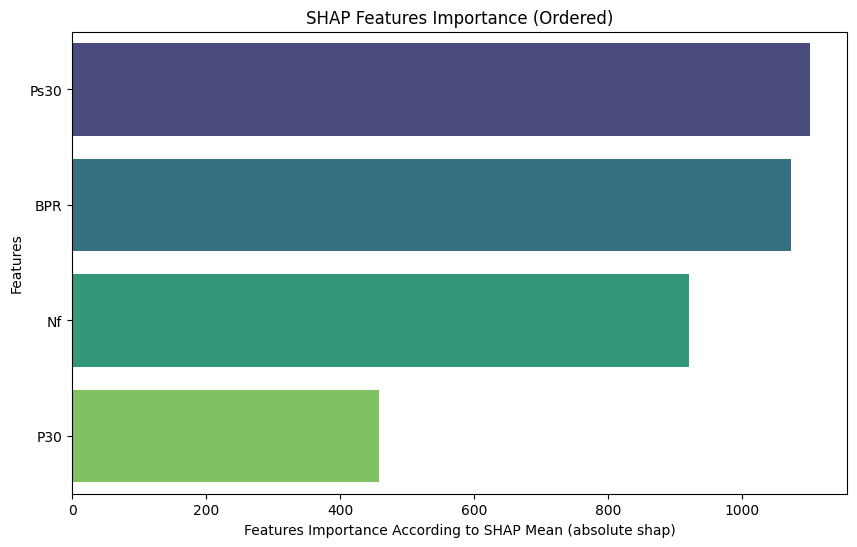

In [11]:
df_features = pd.DataFrame({
    "Feature": remaining_sensors001,
    "Importance": somme_abs_par_feature001
})

# Trier les données par importance décroissante
df_features = df_features.sort_values(by="Importance", ascending=False)

# Création du barplot ordonné
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=df_features,
    palette="viridis"
)
plt.xlabel("Features Importance According to SHAP Mean (absolute shap)")
plt.ylabel("Features")
plt.title("SHAP Features Importance (Ordered)")
plt.show()


In [12]:
# # Convertir les données en DataFrame pour faciliter le tri
# plt.figure(figsize=(15, 12))
# for i in range(4) : 
#     e1 = shap_values_reshaped[i:i+1, :, :]
#     somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
#     # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


#     df_features = pd.DataFrame({
#         "Feature": remaining_sensors,
#         "Importance": somme_abs_par_feature
#     })

#     # Trier les données par importance décroissante
#     df_features = df_features.sort_values(by="Importance", ascending=False)
#     plt.subplot(2,2, i+1)
#     # Création du barplot ordonné
#     sns.barplot(
#         x="Importance",
#         y="Feature",
#         data=df_features,
#         palette="viridis"
#     )
#     plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
#     plt.ylabel("Features")
#     plt.title("SHAP Features Importance (absolute Values)")
# plt.savefig('images/shap_value001.png')
# plt.show()


### FD002

In [13]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD002.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    # 'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "epr"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)
# ## Data cleaning
alpha = 0.3
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(53759, 27) (33991, 26) (259, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,35.0,0.84,100.0,0.0,0.325733,0.271554,0.561254,0.0,...,0.052796,0.497413,0.0,0.400000,0.0,0.0,0.373494,0.323963,120,35.0_0.84_100.0
1,1,2,42.0,0.84,100.0,0.0,0.447218,0.357533,0.470959,0.0,...,0.095143,0.456428,0.0,0.360784,0.0,0.0,0.309302,0.391651,120,42.0_0.84_100.0
2,1,3,25.0,0.62,60.0,0.0,0.553232,0.355037,0.466030,0.0,...,0.110085,0.414226,0.0,0.470015,0.0,0.0,0.286071,0.531223,120,25.0_0.62_60.0
3,1,4,42.0,0.84,100.0,0.0,0.495285,0.387258,0.447732,0.0,...,0.107374,0.381830,0.0,0.372189,0.0,0.0,0.359184,0.632675,120,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.528642,0.383824,0.455578,0.0,...,0.104597,0.378322,0.0,0.454340,0.0,0.0,0.343109,0.552861,120,25.0_0.62_60.0


In [14]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 16.603718	0.0	1.343367e+03	0.0	275.683502	0.0	0.20	[32]	0.1	tanh	128	40
results002 = pd.DataFrame()

for SEED in range(1):  
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.2
    sequence_length = 40
    epochs = 50
    nodes_per_layer = [32]
    dropout = 0.1
    activation = 'tanh'
    batch_size = 128
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results002 = pd.concat([results002, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results002.to_csv('results/base/fd002.csv')

(43619, 40, 4) (43619, 1) (259, 40, 4)
Epoch 1/50
341/341 [==============================] - 4s 9ms/step - loss: 2214.2354 - val_loss: 1642.6108
Epoch 2/50
341/341 [==============================] - 3s 8ms/step - loss: 1018.1802 - val_loss: 488.0606
Epoch 3/50
341/341 [==============================] - 3s 9ms/step - loss: 399.2461 - val_loss: 359.0230
Epoch 4/50
341/341 [==============================] - 3s 8ms/step - loss: 347.6960 - val_loss: 342.8446
Epoch 5/50
341/341 [==============================] - 3s 8ms/step - loss: 326.0885 - val_loss: 276.4044
Epoch 6/50
341/341 [==============================] - 3s 9ms/step - loss: 318.6015 - val_loss: 284.3752
Epoch 7/50
341/341 [==============================] - 3s 9ms/step - loss: 312.9294 - val_loss: 288.9886
Epoch 8/50
341/341 [==============================] - 3s 10ms/step - loss: 307.7955 - val_loss: 307.5814
Epoch 9/50
341/341 [==============================] - 3s 10ms/step - loss: 298.9600 - val_loss: 309.4959
Epoch 10/50
341/341 

In [15]:
results002

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.711434,0.0,1082.988826,0.0,216.4263,0.0,[32],0.1,tanh,128,40,185.173015


##### Generation de shap shap values

In [16]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:100], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1480/1480 [==============================] - 4s 3ms/step


  1%|          | 1/100 [00:05<08:46,  5.32s/it]

1480/1480 [==============================] - 5s 3ms/step


  2%|▏         | 2/100 [00:11<09:12,  5.63s/it]

1480/1480 [==============================] - 4s 3ms/step


  3%|▎         | 3/100 [00:16<08:41,  5.37s/it]

1480/1480 [==============================] - 5s 3ms/step


  4%|▍         | 4/100 [00:21<08:48,  5.50s/it]

1480/1480 [==============================] - 4s 3ms/step


  5%|▌         | 5/100 [00:27<08:37,  5.45s/it]

1480/1480 [==============================] - 6s 4ms/step


  6%|▌         | 6/100 [00:34<09:41,  6.18s/it]

1480/1480 [==============================] - 4s 2ms/step


  7%|▋         | 7/100 [00:39<08:48,  5.68s/it]

1480/1480 [==============================] - 3s 2ms/step


  8%|▊         | 8/100 [00:45<08:51,  5.78s/it]

1480/1480 [==============================] - 4s 2ms/step


  9%|▉         | 9/100 [00:50<08:13,  5.42s/it]

1480/1480 [==============================] - 4s 2ms/step


 10%|█         | 10/100 [00:56<08:25,  5.61s/it]

1480/1480 [==============================] - 4s 3ms/step


 11%|█         | 11/100 [01:01<07:57,  5.37s/it]

1480/1480 [==============================] - 4s 2ms/step


 12%|█▏        | 12/100 [01:05<07:33,  5.16s/it]

1480/1480 [==============================] - 4s 3ms/step


 13%|█▎        | 13/100 [01:10<07:21,  5.07s/it]

1480/1480 [==============================] - 4s 3ms/step


 14%|█▍        | 14/100 [01:15<07:10,  5.01s/it]

1480/1480 [==============================] - 4s 3ms/step


 15%|█▌        | 15/100 [01:20<07:04,  5.00s/it]

1480/1480 [==============================] - 4s 3ms/step


 16%|█▌        | 16/100 [01:25<07:04,  5.06s/it]

1480/1480 [==============================] - 4s 2ms/step


 17%|█▋        | 17/100 [01:30<06:53,  4.99s/it]

1480/1480 [==============================] - 4s 3ms/step


 18%|█▊        | 18/100 [01:35<06:50,  5.00s/it]

1480/1480 [==============================] - 4s 3ms/step


 19%|█▉        | 19/100 [01:40<06:43,  4.98s/it]

1480/1480 [==============================] - 4s 3ms/step


 20%|██        | 20/100 [01:46<07:04,  5.31s/it]

1480/1480 [==============================] - 4s 3ms/step


 21%|██        | 21/100 [01:51<06:54,  5.25s/it]

1480/1480 [==============================] - 4s 3ms/step


 22%|██▏       | 22/100 [01:56<06:47,  5.23s/it]

1480/1480 [==============================] - 4s 3ms/step


 23%|██▎       | 23/100 [02:01<06:35,  5.13s/it]

1480/1480 [==============================] - 4s 3ms/step


 24%|██▍       | 24/100 [02:06<06:33,  5.17s/it]

1480/1480 [==============================] - 5s 3ms/step


 25%|██▌       | 25/100 [02:12<06:42,  5.36s/it]

1480/1480 [==============================] - 4s 3ms/step


 26%|██▌       | 26/100 [02:17<06:30,  5.28s/it]

1480/1480 [==============================] - 4s 3ms/step


 27%|██▋       | 27/100 [02:23<06:29,  5.33s/it]

1480/1480 [==============================] - 4s 3ms/step


 28%|██▊       | 28/100 [02:29<06:34,  5.48s/it]

1480/1480 [==============================] - 4s 2ms/step


 29%|██▉       | 29/100 [02:33<06:11,  5.23s/it]

1480/1480 [==============================] - 5s 3ms/step


 30%|███       | 30/100 [02:39<06:15,  5.36s/it]

1480/1480 [==============================] - 4s 3ms/step


 31%|███       | 31/100 [02:44<06:09,  5.35s/it]

1480/1480 [==============================] - 4s 3ms/step


 32%|███▏      | 32/100 [02:50<06:01,  5.32s/it]

1480/1480 [==============================] - 5s 3ms/step


 33%|███▎      | 33/100 [02:56<06:13,  5.58s/it]

1480/1480 [==============================] - 4s 3ms/step


 34%|███▍      | 34/100 [03:01<06:00,  5.46s/it]

1480/1480 [==============================] - 4s 3ms/step


 35%|███▌      | 35/100 [03:06<05:49,  5.38s/it]

1480/1480 [==============================] - 4s 2ms/step


 36%|███▌      | 36/100 [03:11<05:29,  5.14s/it]

1480/1480 [==============================] - 4s 2ms/step


 37%|███▋      | 37/100 [03:15<05:14,  4.99s/it]

1480/1480 [==============================] - 4s 3ms/step


 38%|███▊      | 38/100 [03:21<05:13,  5.06s/it]

1480/1480 [==============================] - 4s 3ms/step


 39%|███▉      | 39/100 [03:26<05:12,  5.12s/it]

1480/1480 [==============================] - 4s 3ms/step


 40%|████      | 40/100 [03:31<05:02,  5.04s/it]

1480/1480 [==============================] - 5s 3ms/step


 41%|████      | 41/100 [03:37<05:14,  5.33s/it]

1480/1480 [==============================] - 4s 2ms/step


 42%|████▏     | 42/100 [03:41<05:00,  5.17s/it]

1480/1480 [==============================] - 4s 3ms/step


 43%|████▎     | 43/100 [03:47<04:55,  5.19s/it]

1480/1480 [==============================] - 4s 3ms/step


 44%|████▍     | 44/100 [03:52<04:50,  5.19s/it]

1480/1480 [==============================] - 4s 3ms/step


 45%|████▌     | 45/100 [03:57<04:41,  5.13s/it]

1480/1480 [==============================] - 4s 3ms/step


 46%|████▌     | 46/100 [04:02<04:40,  5.20s/it]

1480/1480 [==============================] - 4s 3ms/step


 47%|████▋     | 47/100 [04:08<04:37,  5.24s/it]

1480/1480 [==============================] - 4s 3ms/step


 48%|████▊     | 48/100 [04:14<04:45,  5.49s/it]

1480/1480 [==============================] - 3s 2ms/step


 49%|████▉     | 49/100 [04:18<04:25,  5.21s/it]

1480/1480 [==============================] - 4s 3ms/step


 50%|█████     | 50/100 [04:23<04:17,  5.15s/it]

1480/1480 [==============================] - 4s 2ms/step


 51%|█████     | 51/100 [04:28<04:06,  5.03s/it]

1480/1480 [==============================] - 4s 3ms/step


 52%|█████▏    | 52/100 [04:33<03:59,  4.99s/it]

1480/1480 [==============================] - 4s 3ms/step


 53%|█████▎    | 53/100 [04:38<03:57,  5.05s/it]

1480/1480 [==============================] - 4s 2ms/step


 54%|█████▍    | 54/100 [04:43<03:50,  5.00s/it]

1480/1480 [==============================] - 4s 3ms/step


 55%|█████▌    | 55/100 [04:48<03:45,  5.02s/it]

1480/1480 [==============================] - 4s 3ms/step


 56%|█████▌    | 56/100 [04:53<03:40,  5.00s/it]

1480/1480 [==============================] - 4s 3ms/step


 57%|█████▋    | 57/100 [04:58<03:34,  4.98s/it]

1480/1480 [==============================] - 4s 3ms/step


 58%|█████▊    | 58/100 [05:03<03:32,  5.05s/it]

1480/1480 [==============================] - 4s 3ms/step


 59%|█████▉    | 59/100 [05:09<03:32,  5.18s/it]

1480/1480 [==============================] - 4s 2ms/step


 60%|██████    | 60/100 [05:13<03:22,  5.07s/it]

1480/1480 [==============================] - 4s 2ms/step


 61%|██████    | 61/100 [05:18<03:14,  4.98s/it]

1480/1480 [==============================] - 5s 3ms/step


 62%|██████▏   | 62/100 [05:24<03:16,  5.18s/it]

1480/1480 [==============================] - 4s 3ms/step


 63%|██████▎   | 63/100 [05:30<03:21,  5.44s/it]

1480/1480 [==============================] - 4s 3ms/step


 64%|██████▍   | 64/100 [05:35<03:14,  5.40s/it]

1480/1480 [==============================] - 5s 3ms/step


 65%|██████▌   | 65/100 [05:41<03:11,  5.48s/it]

1480/1480 [==============================] - 4s 3ms/step


 66%|██████▌   | 66/100 [05:46<03:02,  5.36s/it]

1480/1480 [==============================] - 4s 3ms/step


 67%|██████▋   | 67/100 [05:51<02:53,  5.25s/it]

1480/1480 [==============================] - 4s 3ms/step


 68%|██████▊   | 68/100 [05:56<02:46,  5.21s/it]

1480/1480 [==============================] - 4s 3ms/step


 69%|██████▉   | 69/100 [06:01<02:40,  5.18s/it]

1480/1480 [==============================] - 4s 3ms/step


 70%|███████   | 70/100 [06:06<02:34,  5.14s/it]

1480/1480 [==============================] - 4s 3ms/step


 71%|███████   | 71/100 [06:11<02:27,  5.07s/it]

1480/1480 [==============================] - 4s 3ms/step


 72%|███████▏  | 72/100 [06:16<02:21,  5.04s/it]

1480/1480 [==============================] - 4s 3ms/step


 73%|███████▎  | 73/100 [06:21<02:19,  5.15s/it]

1480/1480 [==============================] - 4s 3ms/step


 74%|███████▍  | 74/100 [06:26<02:12,  5.08s/it]

1480/1480 [==============================] - 4s 3ms/step


 75%|███████▌  | 75/100 [06:31<02:05,  5.02s/it]

1480/1480 [==============================] - 4s 3ms/step


 76%|███████▌  | 76/100 [06:37<02:02,  5.12s/it]

1480/1480 [==============================] - 4s 3ms/step


 77%|███████▋  | 77/100 [06:41<01:55,  5.02s/it]

1480/1480 [==============================] - 4s 3ms/step


 78%|███████▊  | 78/100 [06:46<01:49,  4.96s/it]

1480/1480 [==============================] - 3s 2ms/step


 79%|███████▉  | 79/100 [06:51<01:41,  4.84s/it]

1480/1480 [==============================] - 4s 2ms/step


 80%|████████  | 80/100 [06:56<01:36,  4.84s/it]

1480/1480 [==============================] - 4s 3ms/step


 81%|████████  | 81/100 [07:01<01:32,  4.88s/it]

1480/1480 [==============================] - 4s 3ms/step


 82%|████████▏ | 82/100 [07:05<01:27,  4.89s/it]

1480/1480 [==============================] - 4s 2ms/step


 83%|████████▎ | 83/100 [07:10<01:21,  4.78s/it]

1480/1480 [==============================] - 4s 3ms/step


 84%|████████▍ | 84/100 [07:15<01:17,  4.87s/it]

1480/1480 [==============================] - 4s 3ms/step


 85%|████████▌ | 85/100 [07:21<01:18,  5.24s/it]

1480/1480 [==============================] - 4s 3ms/step


 86%|████████▌ | 86/100 [07:26<01:13,  5.22s/it]

1480/1480 [==============================] - 4s 3ms/step


 87%|████████▋ | 87/100 [07:31<01:06,  5.15s/it]

1480/1480 [==============================] - 4s 3ms/step


 88%|████████▊ | 88/100 [07:37<01:02,  5.25s/it]

1480/1480 [==============================] - 4s 3ms/step


 89%|████████▉ | 89/100 [07:42<00:57,  5.24s/it]

1480/1480 [==============================] - 4s 3ms/step


 90%|█████████ | 90/100 [07:47<00:52,  5.28s/it]

1480/1480 [==============================] - 4s 3ms/step


 91%|█████████ | 91/100 [07:53<00:47,  5.30s/it]

1480/1480 [==============================] - 4s 3ms/step


 92%|█████████▏| 92/100 [07:58<00:42,  5.31s/it]

1480/1480 [==============================] - 4s 3ms/step


 93%|█████████▎| 93/100 [08:04<00:38,  5.54s/it]

1480/1480 [==============================] - 4s 3ms/step


 94%|█████████▍| 94/100 [08:09<00:32,  5.44s/it]

1480/1480 [==============================] - 5s 3ms/step


 95%|█████████▌| 95/100 [08:15<00:27,  5.56s/it]

1480/1480 [==============================] - 5s 3ms/step


 96%|█████████▌| 96/100 [08:21<00:22,  5.69s/it]

1480/1480 [==============================] - 4s 3ms/step


 97%|█████████▋| 97/100 [08:26<00:16,  5.55s/it]

1480/1480 [==============================] - 3s 2ms/step


 98%|█████████▊| 98/100 [08:31<00:10,  5.11s/it]

1480/1480 [==============================] - 3s 2ms/step


 99%|█████████▉| 99/100 [08:35<00:04,  4.87s/it]

1480/1480 [==============================] - 3s 2ms/step


100%|██████████| 100/100 [08:39<00:00,  5.20s/it]


In [17]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)

list_shap_values = []
for i in range(100):
    shap_values_2D = shap_values[0].reshape(-1,features)
    list_shap_values.append(np.abs(shap_values_2D).sum(axis=0))  # Somme sur samples et timesteps
somme_abs_par_feature002 = np.array(list_shap_values).sum(axis = 0)
remaining_sensors002 = remaining_sensors
somme_abs_par_feature002

Shape reshaped: (100, 40, 4)


array([11616.18433772,  3208.02315141,  2769.68843916,  1963.14923026])

In [18]:
# # Convertir les données en DataFrame pour faciliter le tri
# plt.figure(figsize=(15, 12))
# for i in range(4) : 
#     e1 = shap_values_reshaped[i:i+1, :, :]
#     somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
#     # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


#     df_features = pd.DataFrame({
#         "Feature": remaining_sensors,
#         "Importance": somme_abs_par_feature
#     })

#     # Trier les données par importance décroissante
#     df_features = df_features.sort_values(by="Importance", ascending=False)
#     plt.subplot(2,2, i+1)
#     # Création du barplot ordonné
#     sns.barplot(
#         x="Importance",
#         y="Feature",
#         data=df_features,
#         palette="viridis"
#     )
#     plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
#     plt.ylabel("Features")
#     plt.title("SHAP Features Importance (absolute Values)")
# plt.savefig('images/shap_value002.png')
# plt.show()


#### FD003

In [19]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD003.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR','htBleed','W31','W32']
remaining_sensors = ["Ps30", "NRc", "W31", "BPR"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 125
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(24720, 27) (16596, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,0.0,100.0,0.0,0.378788,0.341211,0.279748,0.0,...,0.238238,0.618635,0.0,0.272727,0.0,0.0,0.546584,0.469595,125,-0.0_0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.403623,0.371855,0.295333,0.0,...,0.270487,0.639660,0.0,0.320574,0.0,0.0,0.515568,0.505576,125,0.0_-0.0_100.0
2,1,3,-0.0,-0.0,100.0,0.0,0.376607,0.365007,0.349504,0.0,...,0.273559,0.596319,0.0,0.302918,0.0,0.0,0.478323,0.472777,125,-0.0_-0.0_100.0
3,1,4,-0.0,0.0,100.0,0.0,0.426586,0.372434,0.306566,0.0,...,0.265180,0.574722,0.0,0.320574,0.0,0.0,0.471081,0.455219,125,-0.0_0.0_100.0
4,1,5,0.0,0.0,100.0,0.0,0.370454,0.395376,0.307426,0.0,...,0.268241,0.570330,0.0,0.331090,0.0,0.0,0.495162,0.473204,125,0.0_0.0_100.0


In [20]:
%%time

# 	RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 43	15.404917	0.0	8.255290e+02	0.0	237.311462	0.0	0.10	[64]	0.2	tanh	32	35
results003 = pd.DataFrame()

for SEED in range(1):
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 35
    epochs = 40
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results003 = pd.concat([results003, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results003.to_csv('results/base/fd003.csv')

(21320, 35, 4) (21320, 1) (100, 35, 4)
Epoch 1/40
667/667 [==============================] - 6s 8ms/step - loss: 1926.2242 - val_loss: 626.0947
Epoch 2/40
667/667 [==============================] - 5s 7ms/step - loss: 509.8139 - val_loss: 495.4820
Epoch 3/40
667/667 [==============================] - 5s 8ms/step - loss: 446.2320 - val_loss: 526.9447
Epoch 4/40
667/667 [==============================] - 4s 7ms/step - loss: 388.7859 - val_loss: 543.0040
Epoch 5/40
667/667 [==============================] - 4s 7ms/step - loss: 350.8421 - val_loss: 445.9988
Epoch 6/40
667/667 [==============================] - 4s 7ms/step - loss: 337.5993 - val_loss: 432.8873
Epoch 7/40
667/667 [==============================] - 4s 7ms/step - loss: 327.3005 - val_loss: 467.6749
Epoch 8/40
667/667 [==============================] - 5s 7ms/step - loss: 308.2838 - val_loss: 336.4559
Epoch 9/40
667/667 [==============================] - 4s 7ms/step - loss: 305.0323 - val_loss: 374.2013
Epoch 10/40
667/667 [===

In [21]:
results003

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,15.549646,0.0,1355.01579,0.0,241.791489,0.0,[64],0.2,tanh,32,35,202.743352


### Shap explanation Generation

In [22]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:100], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


1/1 [==============================] - 0s 24ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1455/1455 [==============================] - 5s 4ms/step


  1%|          | 1/100 [00:06<10:27,  6.34s/it]

1455/1455 [==============================] - 5s 3ms/step


  2%|▏         | 2/100 [00:11<09:36,  5.89s/it]

1455/1455 [==============================] - 5s 3ms/step


  3%|▎         | 3/100 [00:17<09:23,  5.81s/it]

1455/1455 [==============================] - 4s 3ms/step


  4%|▍         | 4/100 [00:22<08:43,  5.45s/it]

1455/1455 [==============================] - 5s 3ms/step


  5%|▌         | 5/100 [00:28<08:40,  5.48s/it]

1455/1455 [==============================] - 4s 3ms/step


  6%|▌         | 6/100 [00:33<08:22,  5.35s/it]

1455/1455 [==============================] - 4s 3ms/step


  7%|▋         | 7/100 [00:38<08:15,  5.33s/it]

1455/1455 [==============================] - 4s 3ms/step


  8%|▊         | 8/100 [00:43<08:11,  5.34s/it]

1455/1455 [==============================] - 5s 4ms/step


  9%|▉         | 9/100 [00:49<08:29,  5.60s/it]

1455/1455 [==============================] - 6s 4ms/step


 10%|█         | 10/100 [00:57<09:06,  6.07s/it]

1455/1455 [==============================] - 5s 3ms/step


 11%|█         | 11/100 [01:02<08:52,  5.99s/it]

1455/1455 [==============================] - 5s 3ms/step


 12%|█▏        | 12/100 [01:08<08:42,  5.94s/it]

1455/1455 [==============================] - 5s 3ms/step


 13%|█▎        | 13/100 [01:14<08:39,  5.98s/it]

1455/1455 [==============================] - 5s 3ms/step


 14%|█▍        | 14/100 [01:20<08:27,  5.90s/it]

1455/1455 [==============================] - 5s 3ms/step


 15%|█▌        | 15/100 [01:26<08:19,  5.87s/it]

1455/1455 [==============================] - 5s 3ms/step


 16%|█▌        | 16/100 [01:32<08:10,  5.84s/it]

1455/1455 [==============================] - 4s 3ms/step


 17%|█▋        | 17/100 [01:37<07:58,  5.76s/it]

1455/1455 [==============================] - 5s 3ms/step


 18%|█▊        | 18/100 [01:43<07:48,  5.72s/it]

1455/1455 [==============================] - 5s 3ms/step


 19%|█▉        | 19/100 [01:49<07:50,  5.81s/it]

1455/1455 [==============================] - 5s 3ms/step


 20%|██        | 20/100 [01:54<07:40,  5.76s/it]

1455/1455 [==============================] - 5s 3ms/step


 21%|██        | 21/100 [02:00<07:35,  5.77s/it]

1455/1455 [==============================] - 5s 3ms/step


 22%|██▏       | 22/100 [02:06<07:28,  5.75s/it]

1455/1455 [==============================] - 5s 3ms/step


 23%|██▎       | 23/100 [02:12<07:21,  5.73s/it]

1455/1455 [==============================] - 5s 3ms/step


 24%|██▍       | 24/100 [02:18<07:23,  5.83s/it]

1455/1455 [==============================] - 5s 3ms/step


 25%|██▌       | 25/100 [02:24<07:24,  5.92s/it]

1455/1455 [==============================] - 5s 3ms/step


 26%|██▌       | 26/100 [02:30<07:22,  5.98s/it]

1455/1455 [==============================] - 5s 3ms/step


 27%|██▋       | 27/100 [02:36<07:19,  6.02s/it]

1455/1455 [==============================] - 5s 4ms/step


 28%|██▊       | 28/100 [02:43<07:23,  6.16s/it]

1455/1455 [==============================] - 5s 3ms/step


 29%|██▉       | 29/100 [02:49<07:14,  6.12s/it]

1455/1455 [==============================] - 5s 4ms/step


 30%|███       | 30/100 [02:55<07:10,  6.16s/it]

1455/1455 [==============================] - 5s 3ms/step


 31%|███       | 31/100 [03:01<07:05,  6.16s/it]

1455/1455 [==============================] - 6s 4ms/step


 32%|███▏      | 32/100 [03:08<07:14,  6.39s/it]

1455/1455 [==============================] - 6s 4ms/step


 33%|███▎      | 33/100 [03:15<07:14,  6.49s/it]

1455/1455 [==============================] - 6s 4ms/step


 34%|███▍      | 34/100 [03:22<07:16,  6.61s/it]

1455/1455 [==============================] - 5s 4ms/step


 35%|███▌      | 35/100 [03:28<07:10,  6.62s/it]

1455/1455 [==============================] - 5s 4ms/step


 36%|███▌      | 36/100 [03:34<06:57,  6.52s/it]

1455/1455 [==============================] - 5s 3ms/step


 37%|███▋      | 37/100 [03:41<06:44,  6.42s/it]

1455/1455 [==============================] - 4s 3ms/step


 38%|███▊      | 38/100 [03:46<06:16,  6.08s/it]

1455/1455 [==============================] - 4s 3ms/step


 39%|███▉      | 39/100 [03:51<05:52,  5.79s/it]

1455/1455 [==============================] - 4s 3ms/step


 40%|████      | 40/100 [03:56<05:34,  5.57s/it]

1455/1455 [==============================] - 5s 3ms/step


 41%|████      | 41/100 [04:02<05:27,  5.55s/it]

1455/1455 [==============================] - 4s 3ms/step


 42%|████▏     | 42/100 [04:08<05:29,  5.68s/it]

1455/1455 [==============================] - 5s 4ms/step


 43%|████▎     | 43/100 [04:14<05:32,  5.84s/it]

1455/1455 [==============================] - 5s 3ms/step


 44%|████▍     | 44/100 [04:19<05:24,  5.79s/it]

1455/1455 [==============================] - 4s 3ms/step


 45%|████▌     | 45/100 [04:25<05:10,  5.64s/it]

1455/1455 [==============================] - 4s 3ms/step


 46%|████▌     | 46/100 [04:30<05:00,  5.56s/it]

1455/1455 [==============================] - 4s 3ms/step


 47%|████▋     | 47/100 [04:36<04:52,  5.52s/it]

1455/1455 [==============================] - 5s 3ms/step


 48%|████▊     | 48/100 [04:41<04:50,  5.59s/it]

1455/1455 [==============================] - 4s 3ms/step


 49%|████▉     | 49/100 [04:47<04:42,  5.55s/it]

1455/1455 [==============================] - 5s 3ms/step


 50%|█████     | 50/100 [04:52<04:38,  5.57s/it]

1455/1455 [==============================] - 4s 3ms/step


 51%|█████     | 51/100 [04:58<04:33,  5.58s/it]

1455/1455 [==============================] - 4s 3ms/step


 52%|█████▏    | 52/100 [05:03<04:26,  5.55s/it]

1455/1455 [==============================] - 5s 3ms/step


 53%|█████▎    | 53/100 [05:09<04:27,  5.68s/it]

1455/1455 [==============================] - 5s 4ms/step


 54%|█████▍    | 54/100 [05:16<04:31,  5.90s/it]

1455/1455 [==============================] - 5s 4ms/step


 55%|█████▌    | 55/100 [05:22<04:33,  6.08s/it]

1455/1455 [==============================] - 5s 3ms/step


 56%|█████▌    | 56/100 [05:29<04:30,  6.15s/it]

1455/1455 [==============================] - 7s 5ms/step


 57%|█████▋    | 57/100 [05:37<04:48,  6.71s/it]

1455/1455 [==============================] - 5s 4ms/step


 58%|█████▊    | 58/100 [05:43<04:36,  6.58s/it]

1455/1455 [==============================] - 5s 4ms/step


 59%|█████▉    | 59/100 [05:50<04:30,  6.59s/it]

1455/1455 [==============================] - 5s 4ms/step


 60%|██████    | 60/100 [05:56<04:23,  6.58s/it]

1455/1455 [==============================] - 6s 4ms/step


 61%|██████    | 61/100 [06:03<04:21,  6.69s/it]

1455/1455 [==============================] - 5s 3ms/step


 62%|██████▏   | 62/100 [06:09<04:03,  6.41s/it]

1455/1455 [==============================] - 5s 3ms/step


 63%|██████▎   | 63/100 [06:15<03:49,  6.20s/it]

1455/1455 [==============================] - 5s 3ms/step


 64%|██████▍   | 64/100 [06:21<03:41,  6.15s/it]

1455/1455 [==============================] - 4s 3ms/step


 65%|██████▌   | 65/100 [06:26<03:28,  5.95s/it]

1455/1455 [==============================] - 5s 3ms/step


 66%|██████▌   | 66/100 [06:32<03:18,  5.85s/it]

1455/1455 [==============================] - 5s 3ms/step


 67%|██████▋   | 67/100 [06:37<03:11,  5.80s/it]

1455/1455 [==============================] - 5s 3ms/step


 68%|██████▊   | 68/100 [06:43<03:04,  5.76s/it]

1455/1455 [==============================] - 5s 3ms/step


 69%|██████▉   | 69/100 [06:49<02:58,  5.77s/it]

1455/1455 [==============================] - 5s 3ms/step


 70%|███████   | 70/100 [06:55<02:52,  5.75s/it]

1455/1455 [==============================] - 5s 3ms/step


 71%|███████   | 71/100 [07:00<02:48,  5.80s/it]

1455/1455 [==============================] - 5s 3ms/step


 72%|███████▏  | 72/100 [07:06<02:42,  5.79s/it]

1455/1455 [==============================] - 5s 3ms/step


 73%|███████▎  | 73/100 [07:12<02:37,  5.85s/it]

1455/1455 [==============================] - 5s 3ms/step


 74%|███████▍  | 74/100 [07:18<02:32,  5.86s/it]

1455/1455 [==============================] - 5s 4ms/step


 75%|███████▌  | 75/100 [07:24<02:29,  6.00s/it]

1455/1455 [==============================] - 5s 4ms/step


 76%|███████▌  | 76/100 [07:31<02:26,  6.08s/it]

1455/1455 [==============================] - 5s 3ms/step


 77%|███████▋  | 77/100 [07:37<02:19,  6.08s/it]

1455/1455 [==============================] - 5s 3ms/step


 78%|███████▊  | 78/100 [07:43<02:12,  6.02s/it]

1455/1455 [==============================] - 5s 3ms/step


 79%|███████▉  | 79/100 [07:49<02:06,  6.00s/it]

1455/1455 [==============================] - 5s 4ms/step


 80%|████████  | 80/100 [07:55<02:01,  6.08s/it]

1455/1455 [==============================] - 5s 3ms/step


 81%|████████  | 81/100 [08:01<01:55,  6.06s/it]

1455/1455 [==============================] - 5s 3ms/step


 82%|████████▏ | 82/100 [08:06<01:46,  5.91s/it]

1455/1455 [==============================] - 4s 3ms/step


 83%|████████▎ | 83/100 [08:12<01:37,  5.73s/it]

1455/1455 [==============================] - 5s 4ms/step


 84%|████████▍ | 84/100 [08:18<01:35,  5.95s/it]

1455/1455 [==============================] - 5s 3ms/step


 85%|████████▌ | 85/100 [08:24<01:28,  5.89s/it]

1455/1455 [==============================] - 5s 3ms/step


 86%|████████▌ | 86/100 [08:30<01:22,  5.92s/it]

1455/1455 [==============================] - 5s 4ms/step


 87%|████████▋ | 87/100 [08:36<01:18,  6.07s/it]

1455/1455 [==============================] - 6s 4ms/step


 88%|████████▊ | 88/100 [08:43<01:15,  6.26s/it]

1455/1455 [==============================] - 5s 4ms/step


 89%|████████▉ | 89/100 [08:50<01:09,  6.32s/it]

1455/1455 [==============================] - 5s 3ms/step


 90%|█████████ | 90/100 [08:56<01:02,  6.28s/it]

1455/1455 [==============================] - 5s 3ms/step


 91%|█████████ | 91/100 [09:02<00:55,  6.21s/it]

1455/1455 [==============================] - 5s 4ms/step


 92%|█████████▏| 92/100 [09:08<00:49,  6.21s/it]

1455/1455 [==============================] - 4s 3ms/step


 93%|█████████▎| 93/100 [09:13<00:42,  6.00s/it]

1455/1455 [==============================] - 7s 4ms/step


 94%|█████████▍| 94/100 [09:21<00:38,  6.48s/it]

1455/1455 [==============================] - 5s 3ms/step


 95%|█████████▌| 95/100 [09:27<00:31,  6.29s/it]

1455/1455 [==============================] - 4s 3ms/step


 96%|█████████▌| 96/100 [09:32<00:23,  5.94s/it]

1455/1455 [==============================] - 4s 3ms/step


 97%|█████████▋| 97/100 [09:38<00:17,  5.93s/it]

1455/1455 [==============================] - 4s 3ms/step


 98%|█████████▊| 98/100 [09:43<00:11,  5.72s/it]

1455/1455 [==============================] - 4s 3ms/step


 99%|█████████▉| 99/100 [09:48<00:05,  5.54s/it]

1455/1455 [==============================] - 4s 3ms/step


100%|██████████| 100/100 [09:53<00:00,  5.94s/it]


In [23]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)


list_shap_values = []
for i in range(100):
    shap_values_2D = shap_values[0].reshape(-1,features)
    list_shap_values.append(np.abs(shap_values_2D).sum(axis=0))  # Somme sur samples et timesteps
somme_abs_par_feature003 = np.array(list_shap_values).sum(axis = 0)
remaining_sensors003 = remaining_sensors
somme_abs_par_feature003

Shape reshaped: (100, 35, 4)


array([8613.60997622, 3982.39894469, 5983.96406004, 8006.32539657])

In [24]:
# # Convertir les données en DataFrame pour faciliter le tri
# plt.figure(figsize=(15, 12))
# for i in range(4) : 
#     e1 = shap_values_reshaped[i:i+1, :, :]
#     somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
#     # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


#     df_features = pd.DataFrame({
#         "Feature": remaining_sensors,
#         "Importance": somme_abs_par_feature
#     })

#     # Trier les données par importance décroissante
#     df_features = df_features.sort_values(by="Importance", ascending=False)
#     plt.subplot(2,2, i+1)
#     # Création du barplot ordonné
#     sns.barplot(
#         x="Importance",
#         y="Feature",
#         data=df_features,
#         palette="viridis"
#     )
#     plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
#     plt.ylabel("Features")
#     plt.title("SHAP Features Importance (absolute Values)")
# plt.savefig('images/shap_value003.png')
# plt.show()


### FD004

In [25]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "BPR", "farB"] # selection based on main_notebook
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(61249, 27) (41214, 26) (248, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,42.0,0.84,100.0,0.0,0.500000,0.255293,0.278866,0.0,...,0.175935,0.602638,0.0,0.363636,0.0,0.0,0.460000,0.473138,120,42.0_0.84_100.0
1,1,2,20.0,0.70,100.0,0.0,0.296544,0.297306,0.246618,0.0,...,0.144143,0.589484,0.0,0.220096,0.0,0.0,0.374584,0.424327,120,20.0_0.7_100.0
2,1,3,42.0,0.84,100.0,0.0,0.293314,0.279496,0.284639,0.0,...,0.137238,0.645445,0.0,0.239517,0.0,0.0,0.354442,0.475873,120,42.0_0.84_100.0
3,1,4,42.0,0.84,100.0,0.0,0.270575,0.259617,0.308441,0.0,...,0.150673,0.635035,0.0,0.222739,0.0,0.0,0.361874,0.499703,120,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.258382,0.274522,0.277455,0.0,...,0.155717,0.603815,0.0,0.249746,0.0,0.0,0.327772,0.530466,120,25.0_0.62_60.0


In [26]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	nodes	dropout	activation	batch_size	TW
# 1	15.449126	0.0	1.242658e+03	0.0	238.675491	0.0	[64]	0.2	tanh	32	40
# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 2	16.100150	0.0	1.752538e+03	0.0	259.214813	0.0	0.30	[64]	0.2	tanh	32	40
results = pd.DataFrame()

for SEED in range(1):  
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.3
    sequence_length = 40
    epochs = 60
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
            
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results.to_csv('results/base/fd004.csv')

(51538, 40, 5) (51538, 1) (248, 40, 5)
Epoch 1/60
1611/1611 [==============================] - 15s 8ms/step - loss: 1018.6719 - val_loss: 1187.5660
Epoch 2/60
1611/1611 [==============================] - 14s 9ms/step - loss: 449.9142 - val_loss: 758.5734
Epoch 3/60
1611/1611 [==============================] - 15s 10ms/step - loss: 396.0425 - val_loss: 894.2417
Epoch 4/60
1611/1611 [==============================] - 15s 9ms/step - loss: 318.7875 - val_loss: 609.0587
Epoch 5/60
1611/1611 [==============================] - 16s 10ms/step - loss: 302.5323 - val_loss: 430.5175
Epoch 6/60
1611/1611 [==============================] - 18s 11ms/step - loss: 286.1724 - val_loss: 405.9107
Epoch 7/60
1611/1611 [==============================] - 13s 8ms/step - loss: 274.5932 - val_loss: 288.7962
Epoch 8/60
1611/1611 [==============================] - 14s 9ms/step - loss: 257.8383 - val_loss: 271.2102
Epoch 9/60
1611/1611 [==============================] - 16s 10ms/step - loss: 242.6727 - val_loss: 2

In [27]:
results

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,16.059912,0.0,1416.982323,0.0,257.920776,0.0,[64],0.2,tanh,32,40,1595.381354


In [28]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:100], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


1/1 [==============================] - 0s 30ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1530/1530 [==============================] - 8s 5ms/step


  1%|          | 1/100 [00:10<16:52, 10.22s/it]

1530/1530 [==============================] - 9s 6ms/step


  2%|▏         | 2/100 [00:20<16:55, 10.36s/it]

1530/1530 [==============================] - 9s 6ms/step


  3%|▎         | 3/100 [00:31<16:49, 10.41s/it]

1530/1530 [==============================] - 10s 6ms/step


  4%|▍         | 4/100 [00:42<17:21, 10.85s/it]

1530/1530 [==============================] - 9s 6ms/step


  5%|▌         | 5/100 [00:54<17:31, 11.07s/it]

1530/1530 [==============================] - 10s 6ms/step


  6%|▌         | 6/100 [01:06<17:47, 11.36s/it]

1530/1530 [==============================] - 10s 6ms/step


  7%|▋         | 7/100 [01:17<17:50, 11.51s/it]

1530/1530 [==============================] - 11s 7ms/step


  8%|▊         | 8/100 [01:30<18:11, 11.86s/it]

1530/1530 [==============================] - 8s 6ms/step


  9%|▉         | 9/100 [01:40<17:12, 11.34s/it]

1530/1530 [==============================] - 8s 5ms/step


 10%|█         | 10/100 [01:50<16:15, 10.83s/it]

1530/1530 [==============================] - 8s 5ms/step


 11%|█         | 11/100 [02:00<15:34, 10.50s/it]

1530/1530 [==============================] - 9s 6ms/step


 12%|█▏        | 12/100 [02:10<15:24, 10.51s/it]

1530/1530 [==============================] - 9s 6ms/step


 13%|█▎        | 13/100 [02:20<15:10, 10.46s/it]

1530/1530 [==============================] - 8s 5ms/step


 14%|█▍        | 14/100 [02:31<14:52, 10.38s/it]

1530/1530 [==============================] - 9s 6ms/step


 15%|█▌        | 15/100 [02:41<14:40, 10.36s/it]

1530/1530 [==============================] - 10s 6ms/step


 16%|█▌        | 16/100 [02:53<15:06, 10.79s/it]

1530/1530 [==============================] - 10s 7ms/step


 17%|█▋        | 17/100 [03:05<15:30, 11.21s/it]

1530/1530 [==============================] - 10s 7ms/step


 18%|█▊        | 18/100 [03:18<15:57, 11.68s/it]

1530/1530 [==============================] - 8s 5ms/step


 19%|█▉        | 19/100 [03:28<14:59, 11.11s/it]

1530/1530 [==============================] - 7s 5ms/step


 20%|██        | 20/100 [03:37<14:00, 10.51s/it]

1530/1530 [==============================] - 8s 5ms/step


 21%|██        | 21/100 [03:46<13:21, 10.14s/it]

1530/1530 [==============================] - 8s 5ms/step


 22%|██▏       | 22/100 [03:55<12:47,  9.84s/it]

1530/1530 [==============================] - 8s 5ms/step


 23%|██▎       | 23/100 [04:04<12:26,  9.70s/it]

1530/1530 [==============================] - 8s 5ms/step


 24%|██▍       | 24/100 [04:14<12:15,  9.67s/it]

1530/1530 [==============================] - 8s 6ms/step


 25%|██▌       | 25/100 [04:24<12:15,  9.81s/it]

1530/1530 [==============================] - 8s 5ms/step


 26%|██▌       | 26/100 [04:36<12:42, 10.30s/it]

1530/1530 [==============================] - 8s 5ms/step


 27%|██▋       | 27/100 [04:46<12:28, 10.26s/it]

1530/1530 [==============================] - 9s 6ms/step


 28%|██▊       | 28/100 [04:57<12:37, 10.52s/it]

1530/1530 [==============================] - 9s 6ms/step


 29%|██▉       | 29/100 [05:08<12:32, 10.60s/it]

1530/1530 [==============================] - 9s 6ms/step


 30%|███       | 30/100 [05:19<12:31, 10.74s/it]

1530/1530 [==============================] - 9s 6ms/step


 31%|███       | 31/100 [05:30<12:26, 10.82s/it]

1530/1530 [==============================] - 9s 6ms/step


 32%|███▏      | 32/100 [05:41<12:25, 10.96s/it]

1530/1530 [==============================] - 10s 6ms/step


 33%|███▎      | 33/100 [05:53<12:37, 11.31s/it]

1530/1530 [==============================] - 10s 7ms/step


 34%|███▍      | 34/100 [06:05<12:37, 11.48s/it]

1530/1530 [==============================] - 10s 7ms/step


 35%|███▌      | 35/100 [06:17<12:39, 11.68s/it]

1530/1530 [==============================] - 8s 5ms/step


 36%|███▌      | 36/100 [06:27<11:43, 10.99s/it]

1530/1530 [==============================] - 8s 5ms/step


 37%|███▋      | 37/100 [06:36<10:59, 10.46s/it]

1530/1530 [==============================] - 8s 5ms/step


 38%|███▊      | 38/100 [06:45<10:26, 10.10s/it]

1530/1530 [==============================] - 8s 5ms/step


 39%|███▉      | 39/100 [06:54<10:03,  9.90s/it]

1530/1530 [==============================] - 8s 5ms/step


 40%|████      | 40/100 [07:04<09:50,  9.85s/it]

1530/1530 [==============================] - 8s 5ms/step


 41%|████      | 41/100 [07:14<09:45,  9.92s/it]

1530/1530 [==============================] - 9s 6ms/step


 42%|████▏     | 42/100 [07:25<09:41, 10.02s/it]

1530/1530 [==============================] - 9s 6ms/step


 43%|████▎     | 43/100 [07:36<09:50, 10.36s/it]

1530/1530 [==============================] - 9s 6ms/step


 44%|████▍     | 44/100 [07:47<09:49, 10.53s/it]

1530/1530 [==============================] - 9s 6ms/step


 45%|████▌     | 45/100 [07:57<09:41, 10.57s/it]

1530/1530 [==============================] - 9s 6ms/step


 46%|████▌     | 46/100 [08:09<09:42, 10.79s/it]

1530/1530 [==============================] - 9s 6ms/step


 47%|████▋     | 47/100 [08:19<09:31, 10.78s/it]

1530/1530 [==============================] - 10s 6ms/step


 48%|████▊     | 48/100 [08:31<09:34, 11.05s/it]

1530/1530 [==============================] - 10s 7ms/step


 49%|████▉     | 49/100 [08:43<09:44, 11.45s/it]

1530/1530 [==============================] - 10s 7ms/step


 50%|█████     | 50/100 [08:56<09:46, 11.73s/it]

1530/1530 [==============================] - 8s 5ms/step


 51%|█████     | 51/100 [09:06<09:08, 11.20s/it]

1530/1530 [==============================] - 8s 5ms/step


 52%|█████▏    | 52/100 [09:16<08:38, 10.80s/it]

1530/1530 [==============================] - 8s 5ms/step


 53%|█████▎    | 53/100 [09:25<08:06, 10.36s/it]

1530/1530 [==============================] - 8s 5ms/step


 54%|█████▍    | 54/100 [09:35<07:50, 10.22s/it]

1530/1530 [==============================] - 8s 5ms/step


 55%|█████▌    | 55/100 [09:45<07:40, 10.22s/it]

1530/1530 [==============================] - 9s 6ms/step


 56%|█████▌    | 56/100 [09:55<07:30, 10.23s/it]

1530/1530 [==============================] - 8s 6ms/step


 57%|█████▋    | 57/100 [10:05<07:18, 10.21s/it]

1530/1530 [==============================] - 9s 6ms/step


 58%|█████▊    | 58/100 [10:17<07:21, 10.51s/it]

1530/1530 [==============================] - 10s 7ms/step


 59%|█████▉    | 59/100 [10:29<07:33, 11.07s/it]

1530/1530 [==============================] - 10s 6ms/step


 60%|██████    | 60/100 [10:41<07:28, 11.22s/it]

1530/1530 [==============================] - 9s 6ms/step


 61%|██████    | 61/100 [10:52<07:19, 11.27s/it]

1530/1530 [==============================] - 10s 6ms/step


 62%|██████▏   | 62/100 [11:03<07:08, 11.28s/it]

1530/1530 [==============================] - 10s 7ms/step


 63%|██████▎   | 63/100 [11:16<07:10, 11.62s/it]

1530/1530 [==============================] - 10s 7ms/step


 64%|██████▍   | 64/100 [11:28<07:04, 11.80s/it]

1530/1530 [==============================] - 8s 5ms/step


 65%|██████▌   | 65/100 [11:38<06:34, 11.28s/it]

1530/1530 [==============================] - 8s 5ms/step


 66%|██████▌   | 66/100 [11:47<06:04, 10.73s/it]

1530/1530 [==============================] - 8s 5ms/step


 67%|██████▋   | 67/100 [11:57<05:41, 10.33s/it]

1530/1530 [==============================] - 8s 5ms/step


 68%|██████▊   | 68/100 [12:06<05:23, 10.11s/it]

1530/1530 [==============================] - 8s 5ms/step


 69%|██████▉   | 69/100 [12:16<05:09, 10.00s/it]

1530/1530 [==============================] - 8s 6ms/step


 70%|███████   | 70/100 [12:26<05:01, 10.06s/it]

1530/1530 [==============================] - 8s 5ms/step


 71%|███████   | 71/100 [12:37<04:51, 10.06s/it]

1530/1530 [==============================] - 9s 6ms/step


 72%|███████▏  | 72/100 [12:47<04:48, 10.29s/it]

1530/1530 [==============================] - 10s 6ms/step


 73%|███████▎  | 73/100 [12:59<04:48, 10.69s/it]

1530/1530 [==============================] - 9s 6ms/step


 74%|███████▍  | 74/100 [13:10<04:41, 10.81s/it]

1530/1530 [==============================] - 9s 6ms/step


 75%|███████▌  | 75/100 [13:21<04:32, 10.91s/it]

1530/1530 [==============================] - 10s 6ms/step


 76%|███████▌  | 76/100 [13:33<04:26, 11.09s/it]

1530/1530 [==============================] - 10s 6ms/step


 77%|███████▋  | 77/100 [13:45<04:21, 11.37s/it]

1530/1530 [==============================] - 10s 7ms/step


 78%|███████▊  | 78/100 [13:57<04:14, 11.58s/it]

1530/1530 [==============================] - 10s 7ms/step


 79%|███████▉  | 79/100 [14:09<04:06, 11.72s/it]

1530/1530 [==============================] - 8s 5ms/step


 80%|████████  | 80/100 [14:19<03:42, 11.14s/it]

1530/1530 [==============================] - 8s 5ms/step


 81%|████████  | 81/100 [14:28<03:22, 10.67s/it]

1530/1530 [==============================] - 8s 5ms/step


 82%|████████▏ | 82/100 [14:38<03:09, 10.51s/it]

1530/1530 [==============================] - 9s 6ms/step


 83%|████████▎ | 83/100 [14:49<02:58, 10.51s/it]

1530/1530 [==============================] - 8s 5ms/step


 84%|████████▍ | 84/100 [14:59<02:44, 10.31s/it]

1530/1530 [==============================] - 8s 5ms/step


 85%|████████▌ | 85/100 [15:09<02:33, 10.24s/it]

1530/1530 [==============================] - 9s 6ms/step


 86%|████████▌ | 86/100 [15:20<02:25, 10.40s/it]

1530/1530 [==============================] - 9s 6ms/step


 87%|████████▋ | 87/100 [15:31<02:17, 10.59s/it]

1530/1530 [==============================] - 10s 6ms/step


 88%|████████▊ | 88/100 [15:42<02:10, 10.85s/it]

1530/1530 [==============================] - 10s 7ms/step


 89%|████████▉ | 89/100 [15:54<02:03, 11.26s/it]

1530/1530 [==============================] - 9s 6ms/step


 90%|█████████ | 90/100 [16:05<01:51, 11.11s/it]

1530/1530 [==============================] - 7s 5ms/step


 91%|█████████ | 91/100 [16:14<01:34, 10.49s/it]

1530/1530 [==============================] - 8s 5ms/step


 92%|█████████▏| 92/100 [16:24<01:21, 10.21s/it]

1530/1530 [==============================] - 8s 5ms/step


 93%|█████████▎| 93/100 [16:33<01:09, 10.00s/it]

1530/1530 [==============================] - 8s 5ms/step


 94%|█████████▍| 94/100 [16:45<01:02, 10.45s/it]

1530/1530 [==============================] - 8s 5ms/step


 95%|█████████▌| 95/100 [16:54<00:50, 10.18s/it]

1530/1530 [==============================] - 8s 5ms/step


 96%|█████████▌| 96/100 [17:04<00:40, 10.03s/it]

1530/1530 [==============================] - 8s 6ms/step


 97%|█████████▋| 97/100 [17:14<00:30, 10.08s/it]

1530/1530 [==============================] - 9s 6ms/step


 98%|█████████▊| 98/100 [17:24<00:20, 10.14s/it]

1530/1530 [==============================] - 9s 6ms/step


 99%|█████████▉| 99/100 [17:35<00:10, 10.18s/it]

1530/1530 [==============================] - 9s 6ms/step


100%|██████████| 100/100 [17:45<00:00, 10.66s/it]


In [29]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)

list_shap_values = []
for i in range(100):
    shap_values_2D = shap_values[0].reshape(-1,features)
    list_shap_values.append(np.abs(shap_values_2D).sum(axis=0))  # Somme sur samples et timesteps
somme_abs_par_feature004 = np.array(list_shap_values).sum(axis = 0)
remaining_sensors004 = remaining_sensors
somme_abs_par_feature004


Shape reshaped: (100, 40, 5)


array([ 6654.21822686,  2506.04864861, 14390.27965438,  5996.6232585 ,
        2436.16579094])

In [30]:
# # Convertir les données en DataFrame pour faciliter le tri
# plt.figure(figsize=(15, 12))
# for i in range(4) : 
#     e1 = shap_values_reshaped[i:i+1, :, :]
#     somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
#     # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


#     df_features = pd.DataFrame({
#         "Feature": remaining_sensors,
#         "Importance": somme_abs_par_feature
#     })

#     # Trier les données par importance décroissante
#     df_features = df_features.sort_values(by="Importance", ascending=False)
#     plt.subplot(2,2, i+1)
#     # Création du barplot ordonné
#     sns.barplot(
#         x="Importance",
#         y="Feature",
#         data=df_features,
#         palette="viridis"
#     )
#     plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
#     plt.ylabel("Features")
#     plt.title("SHAP Features Importance (absolute Values)")
# plt.savefig('images/shap_value004.png')
# plt.show()


In [31]:
list_remaining_sensors = [remaining_sensors001, remaining_sensors002, remaining_sensors003, remaining_sensors004]
list_somme_abs_par_feature = [somme_abs_par_feature001, somme_abs_par_feature002, somme_abs_par_feature003, somme_abs_par_feature004]

In [32]:
list_remaining_sensors[i]

IndexError: list index out of range

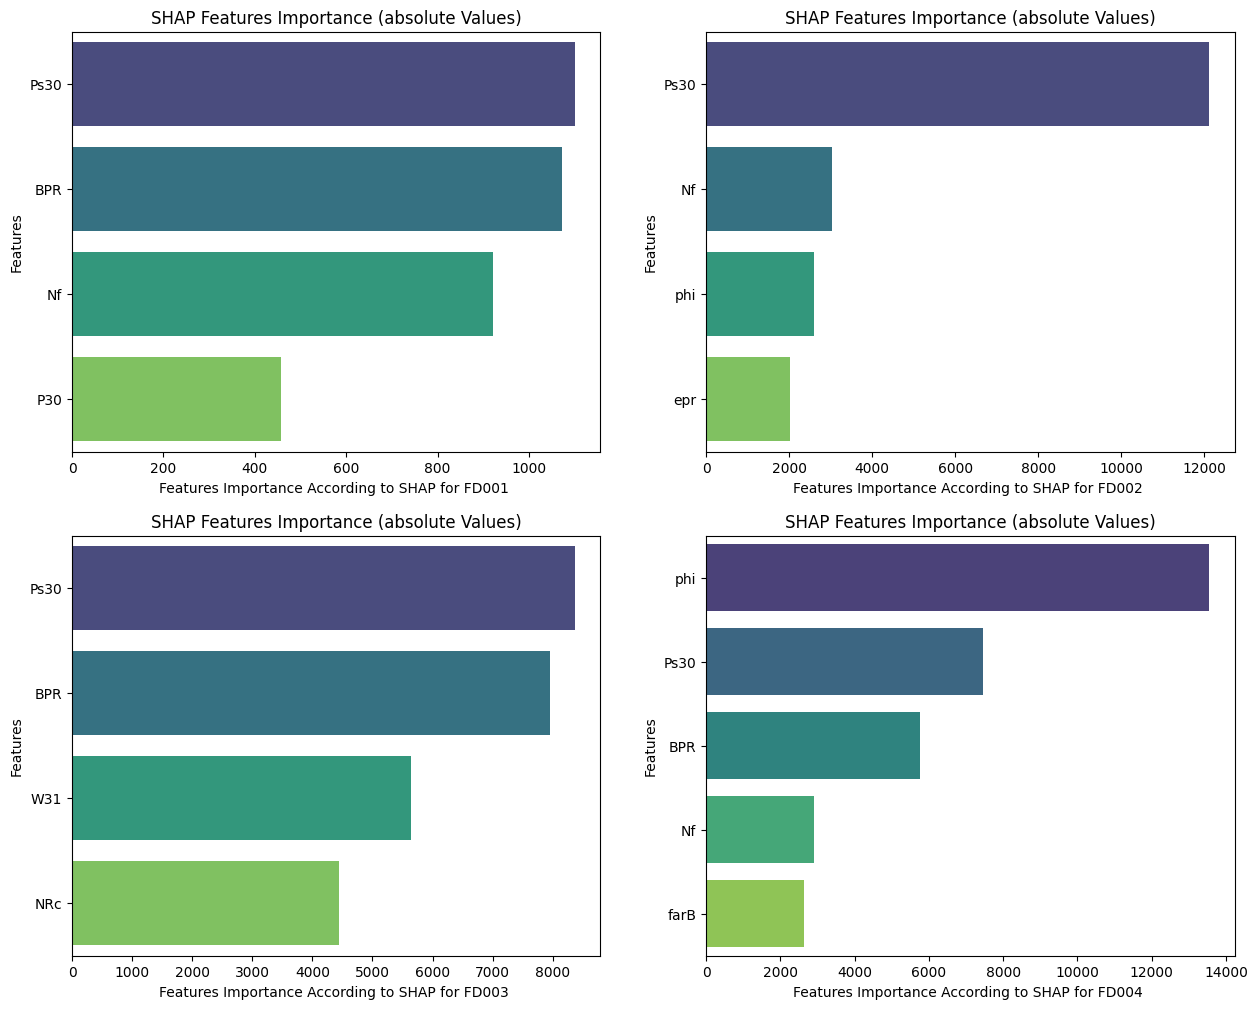

In [ ]:
# Convertir les données en DataFrame pour faciliter le tri
plt.figure(figsize=(15, 12))
for i in range(4) :
    somme_abs_par_feature =list_somme_abs_par_feature[i]  # Somme sur samples et timesteps
    remaining_sensors = list_remaining_sensors[i]
    # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


    df_features = pd.DataFrame({
        "Feature": remaining_sensors,
        "Importance": somme_abs_par_feature
    })

    # Trier les données par importance décroissante
    df_features = df_features.sort_values(by="Importance", ascending=False)
    plt.subplot(2,2, i+1)
    # Création du barplot ordonné
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_features,
        palette="viridis"
    )
    plt.xlabel(f"Features Importance According to SHAP for FD00{i+1} ")
    plt.ylabel("Features")
    plt.title("SHAP Features Importance (absolute Values)")
plt.savefig('images/shap_valueall.png')
plt.show()
